# Setup

In [1]:
%matplotlib inline

import numpy as np
import scipy.signal as sig
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
import datetime

import pandas as pd
from pandas import DataFrame,Series,read_table

General info

In [2]:
savePlots = False    # whether or not to save plots
saveData = False # whether or not to save csv files

saveAsPath = './Fig 02/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)
saveAsName = 'Fig2d_'

In [3]:
#path = '/Users/svcanavan/Dropbox/Coding in progress/00_BudgieSleep/Data_copies/'

birdPaths =    ['../data_copies/01_PreprocessedData/01_BudgieFemale_green1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/05_BudgieFemale_green2/00_Baseline_night/']

arfFilePaths =  ['EEG 2 scored/',
                 'EEG 3 scored/',
                 'EEG 3 scored/',
                 'EEG 4 scored/',
                 'EEG 4 scored/']

### load BEST EEG channels - as determined during manual scoring ####
channelsToLoadEEG_best = [['6 LEEGm-LEEGp', '5 LEEGf-LEEGp'], #, '9 REEGp-LEEGp'], # extra channel to represent R hemisphere
                     ['5 LEEGf-LEEGm', '4 LEEGf-Fgr'], #, '9 REEGf-REEGm'], # extra channel to represent R hemisphere
                     ['9REEGm-REEGp', '4LEEGf-LEEGp'], 
                     ['6LEEGm-LEEGf', '9REEGf-REEGp'], 
                     ['7REEGf-REEGp', '4LEEGf-LEEGp']]


### load ALL of EEG channels ####
channelsToLoadEEG = [['4 LEEGf-Fgr', '5 LEEGf-LEEGp', '6 LEEGm-LEEGp', '7 LEEGp-Fgr', '8 REEGp-Fgr','9 REEGp-LEEGp'],
                     ['4 LEEGf-Fgr','5 LEEGf-LEEGm', '6 LEEGm-LEEGp', '7 REEGf-Fgr', '8 REEGm-Fgr', '9 REEGf-REEGm'],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp'],
                     ['4LEEGf-LEEGp', '5LEEGm-LEEGp', '6LEEGm-LEEGf', '7REEGf-Fgr', '8REEGf-REEGm','9REEGf-REEGp',],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp']]


channelsToLoadEOG = [['1 LEOG-Fgr', '2 REOG-Fgr'],
                     ['2 LEOG-Fgr', '3 REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr']]

birds_LL = [1,2,3]
nBirds_LL = len(birds_LL)

birdPaths_LL = ['../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/01_Constant_light/',]

arfFilePaths_LL =  ['EEG 2 preprocessed/',
                    'EEG 2 preprocessed/',
                    'EEG 2 preprocessed/']

lightsOffSec = np.array([7947, 9675, 9861 + 8*3600, 9873, 13467])  # lights off times in seconds from beginning of file
lightsOnSec = np.array([46449, 48168, 48375+ 8*3600, 48381, 52005]) # Bird 3 gets 8 hours added b/c file starts at 8:00 instead of 16:00

epochLength = 3
sr = 200
scalingFactor = (2**15)*0.195       # scaling/conversion factor from amplitude to uV (when recording arf from jrecord)

stages = ['w','d','u','i','s','r'] # wake, drowsy, unihem sleep, intermediate sleep, SWS, REM
stagesSleep =    ['u','i','s','r']

stagesVideo = ['m','q','d','s','u'] # moving wake, quiet wake, drowsy, sleep, unclear

## Path to scores formatted as CSVs
formatted_scores_path = '../formatted_scores/'

## Path to detect SW ands EM events: use folder w/ EMs and EM artifacts detected during non-sleep
events_path = '../data_copies/SWs_EMs_and_EMartifacts/'

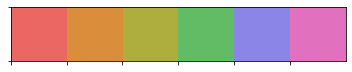

In [4]:
colors = sns.color_palette(np.array([[234,103,99],
[218,142,60],
[174,174,62],
[97,188,101],
[140,133,232],
[225,113,190]])
/255)

sns.palplot(colors)

# colorpalette from iWantHue

Plot-specific info

In [5]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("white")
axis_label_fontsize = 24

# Markers for legends of EEG scoring colors
legendMarkersEEG = []
for stage in range(len(stages)):
    legendMarkersEEG.append(plt.Line2D([0],[0], color=colors[stage], marker='o', linestyle='', alpha=0.7))  

Calculate general variables

In [6]:
lightsOffEp = lightsOffSec / epochLength
lightsOnEp = lightsOnSec / epochLength

nBirds = len(birdPaths)

epochLengthPts = epochLength*sr

nStages = len(stagesSleep)

## Load formatted scores

In [7]:
AllScores = {}
for b in range(nBirds):
    bird_name = 'Bird ' + str(b+1)
    file = formatted_scores_path + 'All_scores_' + bird_name + '.csv'
    data = pd.read_csv(file, index_col=0)
    AllScores[bird_name] = data

## Calculate lights off in Zeitgeber time (s and hrs)
Lights on is 0 

In [8]:
lightsOffDatetime = np.array([], dtype='datetime64')
lightsOnDatetime = np.array([], dtype='datetime64')

for b_num in range(nBirds):
    b_name = 'Bird ' + str(b_num+1)
    Scores = AllScores[b_name]
    startDatetime = np.datetime64(Scores.index.values[0])

    # Calc lights off & on using datetime formats
    lightsOffTimedelta = lightsOffSec[b_num].astype('timedelta64[s]')
    lightsOffDatetime = np.append(lightsOffDatetime, startDatetime + lightsOffTimedelta)
    lightsOnTimedelta = lightsOnSec[b_num].astype('timedelta64[s]')
    lightsOnDatetime = np.append(lightsOnDatetime, startDatetime + lightsOnTimedelta)

In [9]:
lightsOffZeit_s = lightsOffSec - lightsOnSec
lightsOffZeit_hr = lightsOffZeit_s / 3600

## Make table of % of each stage per bin

In [10]:
binSize_min = 60
binSize_s = int(binSize_min*60)
binSize_ep = int(binSize_s/epochLength)

stageProportions_whole_night_all = {}

for b in range(nBirds):
    nBins = int(np.ceil(np.min(lightsOnSec - lightsOffSec)/(60*binSize_min)))

    stageProportions = DataFrame([], columns=range(len(stages)))
    
    b_name = 'Bird ' + str(b+1)
    Scores = AllScores[b_name]

    for bn in range(nBins):

        start = str(lightsOffDatetime[b] +  bn   *np.timedelta64(binSize_s,'s')).replace('T', ' ')
        end   = str(lightsOffDatetime[b] + (bn+1)*np.timedelta64(binSize_s,'s')).replace('T', ' ')

        bn_scores = Scores[str(start):str(end)]
        bn_stage_frequencies = bn_scores['Label (#)'].value_counts(normalize=True,sort=False)
                
        stageProportions = stageProportions.append(bn_stage_frequencies, ignore_index=True)
    
    # Replace NaNs with 0
    stageProportions = stageProportions.fillna(0)
    
    # Calc TST and sleep stages as % TST
    
    stageProportions['TST'] = stageProportions[[2,3,4,5]].sum(axis=1)

    stageProportions['U (% TST)'] = stageProportions[2]/stageProportions['TST']
    stageProportions['I (% TST)'] = stageProportions[3]/stageProportions['TST']
    stageProportions['S (% TST)'] = stageProportions[4]/stageProportions['TST']
    stageProportions['R (% TST)'] = stageProportions[5]/stageProportions['TST']

    # Add to dictionary
    stageProportions_whole_night_all[b] = stageProportions
    

# Plot by individual bird

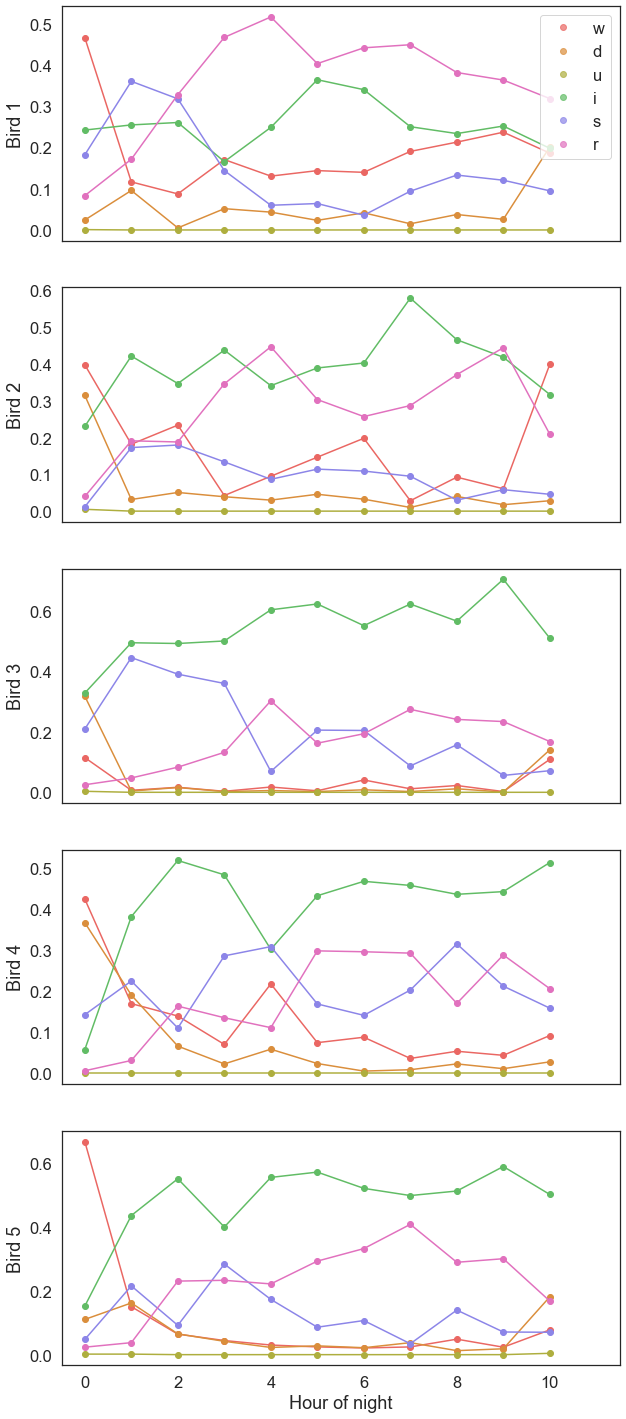

In [11]:
plt.figure(figsize=(10,5*nBirds))

for b in range(nBirds):
    stageProportions = stageProportions_whole_night_all[b]
    
    # Plot
    with sns.color_palette(colors):
        plt.subplot(nBirds,1,b+1)
        plt.plot(stageProportions[[0,1,2,3,4,5]], 'o-')
        
    # Labels etc
    plt.ylabel('Bird ' + str(b+1))
    plt.xlim((-0.5, len(stageProportions)+.5))
        
    # Legend just on first graph
    if b == 0:
        plt.legend(legendMarkersEEG, stages, loc=1)
        
    # X-axis labels just on last graph
    if b < nBirds-1:
        plt.xticks([])
    else:
        plt.xlabel('Hour of night')
        
#if savePlots:
#    plt.savefig(saveAsPath + "Fig2_All_birds_by_hour_of_night.pdf")

### By hour of night: sleep only

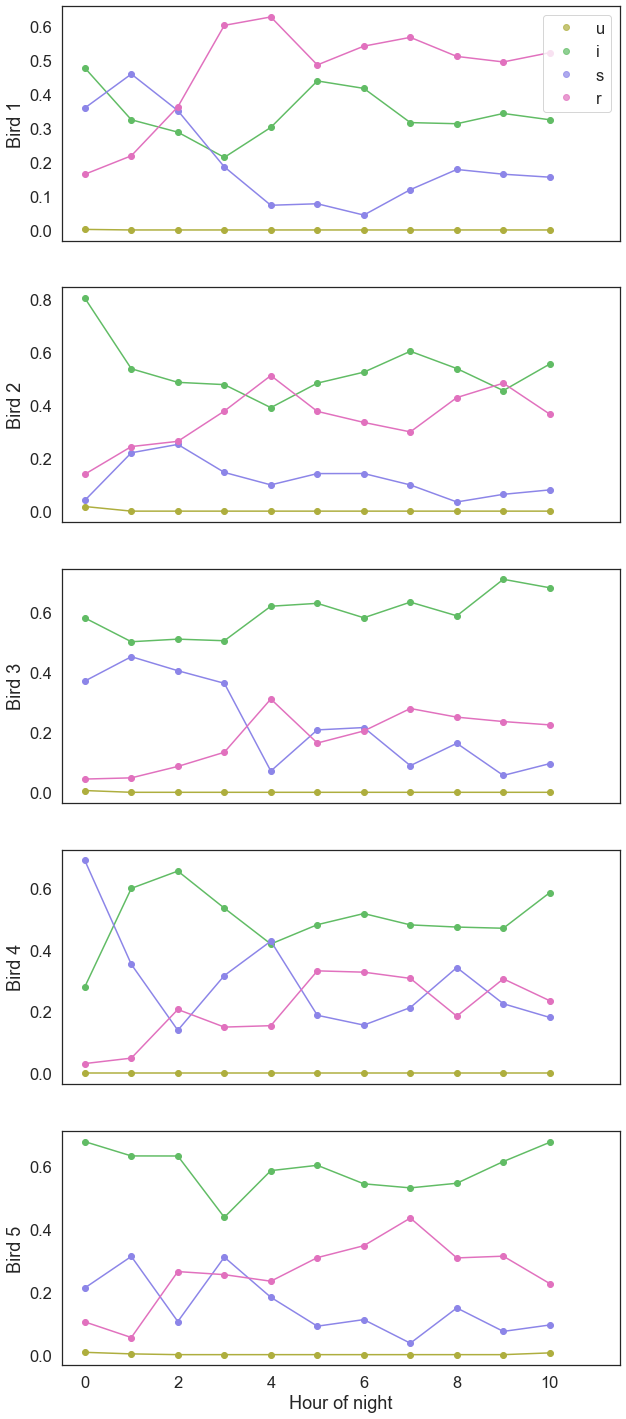

In [12]:
plt.figure(figsize=(10,5*nBirds))

for b in range(nBirds):

    stageProportions = stageProportions_whole_night_all[b]

    # Plot
    with sns.color_palette(colors[2:6]):
        plt.subplot(nBirds,1,b+1)
        plt.plot(stageProportions[['U (% TST)', 'I (% TST)', 'S (% TST)', 'R (% TST)']], 'o-')

    # Labels etc
    plt.ylabel('Bird ' + str(b+1))
    plt.xlim((-0.5, len(stageProportions)+.5))

    # Legend just on first graph
    if b == 0:
        plt.legend(legendMarkersEEG[2:6], stages[2:6], loc=1)

    # X-axis labels just on last graph
    if b < nBirds-1:
        plt.xticks([])
    else:
        plt.xlabel('Hour of night')
        
#if savePlots:
#    plt.savefig(saveAsPath + "Fig2_All_birds_by_percent_of_TST.pdf")

### By hour of sleep

In [13]:
stageProportions_sleep_only = {}

for b in range(nBirds):
    b_name = 'Bird ' + str(b+1)
    Scores = AllScores[b_name]

    Scores_Nighttime = Scores[int(lightsOffEp[b]):int(lightsOnEp[b])]

    Scores_Nighttime_Sleep = Scores_Nighttime[Scores_Nighttime['Label (#)']>=2]

    # Re-index to consecutive numbers starting at 0
    Scores_Nighttime_Sleep = Scores_Nighttime_Sleep.reset_index(drop=True)

    nBins_sleep = int(np.ceil(len(Scores_Nighttime_Sleep)/(binSize_ep)))

    stageProportions = DataFrame([], columns=np.arange(2,6))

    for bn in range(nBins_sleep):

        start_ep = int(bn*binSize_ep)
        end_ep   = int((bn+1)*binSize_ep)

        bn_scores = Scores_Nighttime_Sleep[start_ep:end_ep]
        bn_stage_frequencies = bn_scores['Label (#)'].value_counts(normalize=True,sort=False)

        stageProportions = stageProportions.append(bn_stage_frequencies, ignore_index=True)

    # Replace NaNs with 0
    stageProportions = stageProportions.fillna(0)
    
    # Add to dictionary
    stageProportions_sleep_only[b] = stageProportions

Plot

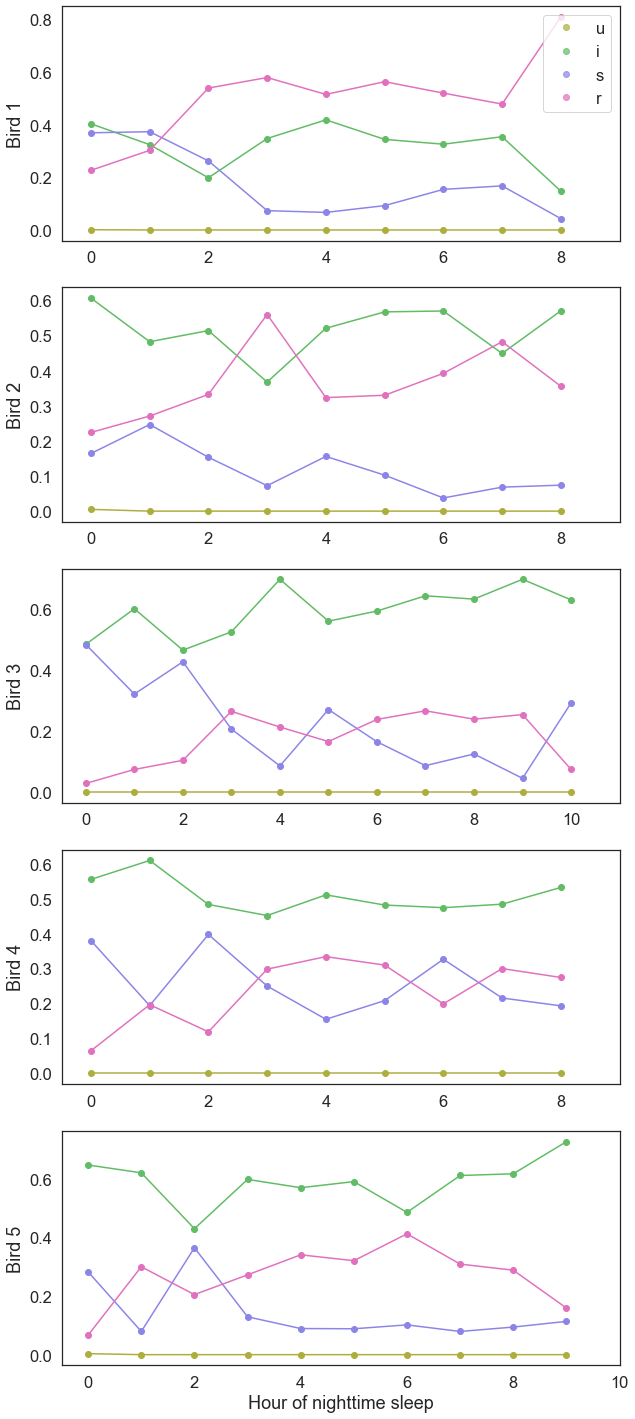

In [14]:
plt.figure(figsize=(10,5*nBirds))

for b in range(nBirds):
    stageProportions = stageProportions_sleep_only[b]
    
    # Plot
    with sns.color_palette(colors[2:6]):
        plt.subplot(nBirds,1,b+1)
        plt.plot(stageProportions[[2,3,4,5]], 'o-')
        
    # Labels etc
    plt.ylabel('Bird ' + str(b+1))
    plt.xlim((-0.5, len(stageProportions)))
        
    # Legend just on first graph
    if b == 0:
        plt.legend(legendMarkersEEG[2:6], stages[2:6], loc=1)
        
    # X-axis labels just on last graph
    if b == nBirds-1:
        plt.xlabel('Hour of nighttime sleep')
        
#if savePlots:
#    plt.savefig(saveAsPath + "Fig2_All_birds_by_hour_of_sleep.pdf")

# Plot summary figures

Organize proportions by stage (instead of by bird)

In [15]:
stageProportions_by_stage = {}

stage_labels_by_hour = stageProportions_whole_night_all[0].columns.values

for st in stage_labels_by_hour:
    stageProportions_stage = DataFrame([])
    
    for b in range(nBirds):
        stageProportions_bird = stageProportions_whole_night_all[b]
        stageProportions_stage['Bird ' + str(b+1)] = stageProportions_bird[st]
        
    stageProportions_by_stage[st] = stageProportions_stage

In [16]:
stage_labels_by_sleep = stageProportions_sleep_only[0].columns.values

for st in stage_labels_by_sleep:
    stageProportions_stage = DataFrame([])
    
    for b in range(nBirds):
        stageProportions_bird = stageProportions_sleep_only[b]
        stageProportions_stage['Bird ' + str(b+1)] = stageProportions_bird[st]
        
    stageProportions_by_stage[str(st) + ' by hr of sleep'] = stageProportions_stage

Find means and SDs over time

In [17]:
Means = DataFrame([])
SDs = DataFrame([])
SEMs = DataFrame([])

for st in stage_labels_by_hour:
    tmp_mean = stageProportions_by_stage[st].mean(axis=1)
    tmp_sd = stageProportions_by_stage[st].std(axis=1)
    nObservations = np.sum((np.isnan(stageProportions_by_stage[st]))==0, axis=1)
    tmp_sem = tmp_sd/np.sqrt(nObservations)
    
    Means[st] = tmp_mean
    SDs[st] = tmp_sd
    SEMs[st] = tmp_sem
    
    
for st in stage_labels_by_sleep:
    tmp_mean = stageProportions_by_stage[str(st) + ' by hr of sleep'].mean(axis=1,skipna=True)
    tmp_sd = stageProportions_by_stage[str(st) + ' by hr of sleep'].std(axis=1,skipna=True)
    nObservations = np.sum((np.isnan(stageProportions_by_stage[str(st) + ' by hr of sleep']))==0, axis=1)
    tmp_sem = tmp_sd/np.sqrt(nObservations)


    
    Means[str(st) + ' by hr of sleep'] = tmp_mean
    SDs[str(st) + ' by hr of sleep'] = tmp_sd
    SEMs[str(st) + ' by hr of sleep'] = tmp_sem

## Plot by hour of night: all stages

### Just the legend

In [18]:
stage_names = ['Wake','Drowsy','Unihem','IS','SWS','REM']


# Markers for legends of EEG scoring colors
legendMarkersEEG = []
for stage in range(len(stages)):
    legendMarkersEEG.append(plt.Line2D([0],[0], color=colors[stage], marker='o',
                                       markersize=10, lw=5, alpha=0.7))

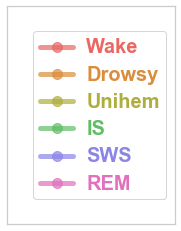

In [19]:
axis_color = [.8,.8,.8]
with plt.rc_context({'axes.edgecolor': axis_color}):  # set color of plot outline

    plt.figure(figsize=(3,4))
    leg = plt.legend(legendMarkersEEG, stage_names, loc=5)
    for text,st in zip(leg.get_texts(),range(len(stages))):
        plt.setp(text, color = colors[st], fontsize=20, fontweight='bold')

    plt.xticks([])
    plt.yticks([])

if savePlots:
    plt.savefig(saveAsPath + "Fig02_Legend.pdf")

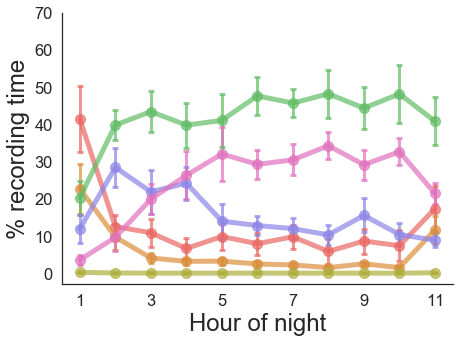

In [20]:
(100*Means[[0,1,2,3,4,5]]).plot(yerr=100*SEMs, 
                                color=colors, figsize=(7,5), 
                                marker='o', markersize=10,
                                linewidth=5, alpha=0.7,
                                capsize=3, capthick=3,
                                elinewidth=3, legend='')

plt.xlabel('Hour of night',fontsize=axis_label_fontsize )
plt.ylabel('% recording time',fontsize=axis_label_fontsize )
plt.xlim((-.5, nBins - .5))
plt.xticks(np.arange(0,11,2), np.arange(1,12,2))
plt.ylim((-3,70))
sns.despine()

if savePlots:
    plt.savefig(saveAsPath + "Fig2d_Summary_by_hour_of_night_allstages.pdf")

## FIGURE 2D: Plot by hour of night: sleep only (%TST)

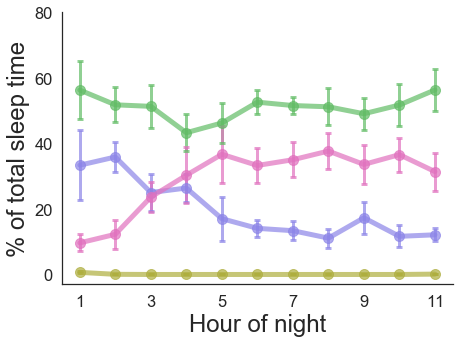

In [21]:
(100*Means[['U (% TST)', 'I (% TST)', 'S (% TST)', 'R (% TST)',]]).plot(yerr=100*SEMs, 
                                color=colors[2:6], figsize=(7,5), 
                                marker='o', markersize=10,
                                linewidth=5, alpha=0.7,
                                capsize=3, capthick=3,
                                elinewidth=3, legend='')

#plt.legend(legendMarkersEEG[2:6], stage_names[2:6], loc=1)

plt.xlabel('Hour of night', fontsize=axis_label_fontsize)
plt.ylabel('% of total sleep time', fontsize=axis_label_fontsize)
plt.xlim((-.5, nBins - .5))
plt.xticks(np.arange(0,11,2), np.arange(1,12,2))
plt.ylim((-3,80))
sns.despine()

if savePlots:
    plt.savefig(saveAsPath + "Fig02_Summary_by_percent_of_TST.pdf")

## Plot by hour of sleep

/Users/svcanavan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


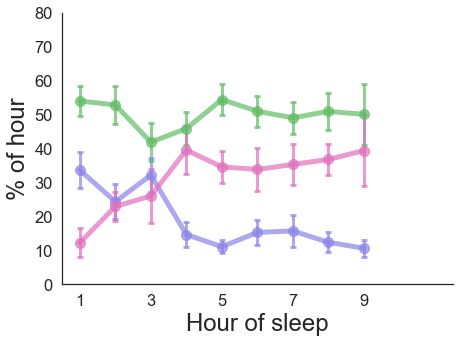

In [22]:
(100*Means[['3 by hr of sleep', '4 by hr of sleep', '5 by hr of sleep']]).plot(
                                yerr=100*SEMs, 
                                color=colors[3:6], figsize=(7,5), 
                                marker='o', markersize=10,
                                linewidth=5, alpha=0.7,
                                capsize=3, capthick=3,
                                elinewidth=3, legend='')

#plt.legend(legendMarkersEEG[2:6], stages[2:6], loc=1)

plt.xlabel('Hour of sleep', fontsize=axis_label_fontsize)
plt.ylabel('% of hour', fontsize=axis_label_fontsize)
plt.xlim((-.5, nBins - .5))
plt.xticks(np.arange(0,9,2), np.arange(1,10,2))
plt.ylim((0,80))
sns.despine()

if savePlots:
    plt.savefig(saveAsPath + "Fig02_Summary_by_hour_of_sleep.pdf")

# Save means and SDs to csv

In [23]:
if saveData:
    Means.to_csv(saveAsPath + 'Fig2d_hour_of_night_Means.csv')
    SDs.to_csv(saveAsPath + 'Fig2d_hour_of_night_SDs.csv')

# FIGURE 2D STATS: Correlation/regression testing

### All hours of night, % TST

In [24]:
test=100*Means['I (% TST)'].dropna()

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)
print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

slope = 0.13034197659535474 , r2 = 0.012735671827302937 , p = 0.7411227031832379


In [25]:
test=100*Means['S (% TST)'].dropna()

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)
print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

slope = -2.3693694953736437 , r2 = 0.7694638615531296 , p = 0.0003897474275402615


In [26]:
test=100*Means['R (% TST)'].dropna()

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)
print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

slope = 2.2650817518617794 , r2 = 0.5885500901126326 , p = 0.005856901849077558


### By hour of sleep, % of hour TST

In [27]:
test=100*Means['3 by hr of sleep'].dropna()   # IS

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)
print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

slope = -0.03376333930987592 , r2 = 0.0005299912299370359 , p = 0.9531216155852626


In [28]:
test=100*Means['4 by hr of sleep'].dropna()   # SWS

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)
print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

slope = -2.6681463988792262 , r2 = 0.6724758993025928 , p = 0.006793106921002458


In [29]:
test=100*Means['5 by hr of sleep'].dropna()   # REM

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)
print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

slope = 2.7141319604113243 , r2 = 0.6731497859805853 , p = 0.0067418643565080455
